In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tfrecorder import TFrecorder
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%pylab inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


# data

In [2]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


# how to write

In [3]:
# info of data
df = pd.DataFrame({'name':['image','label'],
                  'type':['float32','int64'],
                  'shape':[(784,),()],
                  'isbyte':[False,False],
                  "length_type":['fixed','fixed'],
                  "default":[np.NaN,np.NaN]})

In [4]:
df

,default,isbyte,length_type,name,shape,type
0,NaN,False,fixed,image,"(784,)",float32
1,NaN,False,fixed,label,(),int64


# write

In [5]:
tfr = TFrecorder()

In [6]:
mkdir mnist_tfrecord mnist_tfrecord/train mnist_tfrecord/test

In [7]:
dataset = mnist.train
path = 'mnist_tfrecord/train/train'
num_examples_per_file = 1000
num_so_far = 0

writer = tf.python_io.TFRecordWriter('%s%s_%s.tfrecord' %(path, num_so_far, num_examples_per_file))
# write mutilple examples
for i in np.arange(dataset.num_examples):
    features = {}
    # write image of one example
    tfr.feature_writer(df.iloc[0], dataset.images[i], features)
    # write label of one example
    tfr.feature_writer(df.iloc[1], dataset.labels[i], features)
    
    tf_features = tf.train.Features(feature= features)
    tf_example = tf.train.Example(features = tf_features)
    tf_serialized = tf_example.SerializeToString()
    writer.write(tf_serialized)
    
    if i%num_examples_per_file ==0 and i!=0:
        writer.close()
        num_so_far = i
        writer = tf.python_io.TFRecordWriter('%s%s_%s.tfrecord' %(path, num_so_far, i+num_examples_per_file))
writer.close()
data_info_path = 'mnist_tfrecord/data_info.csv'
df.to_csv(data_info_path,index=False)

In [8]:
# 用该方法写测试集的tfrecord文件
dataset = mnist.test
# 写在哪里
path = 'mnist_tfrecord/test/test'
# 把test_set写成符合要求的examples
test_set = []
for i in np.arange(dataset.num_examples):
    # 一个样本
    features = {}
    # 样本中的第一个feature
    features['image'] = dataset.images[i]
    # 样本中的第二个feature
    features['label'] = dataset.labels[i].astype('int64')
    test_set.append(features)
# 直接写入，每个tfrecord中写1000个样本
# 由于测试集里有10000个样本，所以最终会写出10个tfrecord文件
tfr.writer(path, test_set, num_examples_per_file = 1000)

mnist_tfrecord/test/test0_1000.tfrecord
mnist_tfrecord/test/test1000_2000.tfrecord
mnist_tfrecord/test/test2000_3000.tfrecord
mnist_tfrecord/test/test3000_4000.tfrecord
mnist_tfrecord/test/test4000_5000.tfrecord
mnist_tfrecord/test/test5000_6000.tfrecord
mnist_tfrecord/test/test6000_7000.tfrecord
mnist_tfrecord/test/test7000_8000.tfrecord
mnist_tfrecord/test/test8000_9000.tfrecord
mnist_tfrecord/test/test9000_10000.tfrecord
number of features in each example: 2
10000 examples has been written to mnist_tfrecord/test/test
saved data_info to mnist_tfrecord/test/test.csv
    name     type   shape isbyte length_type default
0  image  float32  (784,)  False       fixed     NaN
1  label    int64      ()  False       fixed     NaN


# import function

In [9]:
tfr = TFrecorder()
def input_fn_maker(path, data_info_path, shuffle=False, batch_size = 1, epoch = 1, padding = None):
    def input_fn():
        filenames = tfr.get_filenames(path=path, shuffle=shuffle)
        dataset=tfr.get_dataset(paths=filenames, data_info=data_info_path, shuffle = shuffle, 
                            batch_size = batch_size, epoch = epoch, padding =padding)
        iterator = dataset.make_one_shot_iterator()
        return iterator.get_next()
    return input_fn

In [10]:
padding_info = ({'image':[28,28,1],'label':[]})
test_input_fn = input_fn_maker('mnist_tfrecord/test/',  'mnist_tfrecord/data_info.csv',
                               padding = padding_info)
train_input_fn = input_fn_maker('mnist_tfrecord/train/',  'mnist_tfrecord/data_info.csv', shuffle=True, batch_size = 512,
                               padding = padding_info)
train_eval_fn = input_fn_maker('mnist_tfrecord/train/',  'mnist_tfrecord/data_info.csv', batch_size = 512,
                               padding = padding_info)
test_inputs = test_input_fn()

read dataframe from mnist_tfrecord/data_info.csv
   default  isbyte length_type   name  shape     type
0      NaN   False       fixed  image  [784]  float32
1      NaN   False       fixed  label     []    int64


(1, 28, 28, 1)


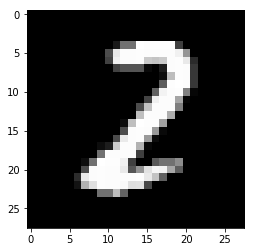

In [11]:
sess =tf.InteractiveSession()
print(test_inputs['image'].eval().shape)
plt.imshow(test_inputs['image'].eval()[0,:,:,0],cmap=plt.cm.gray)